# Data Preprocessing
In our case, data preprocessing comprises the following steps:


1.   Dividing the dataset into training set, validation set and test set
2.   Solving the class unbalance problem, using a combination of undersampling and data augmentation
3. Center cropping images in order to reduce their size by removing the black background (that is useless for the classification problem)
4. Storing the preprocessed dataset for the next steps

## Import Libraries
First of all, let us import all the libraries that we will need later. 

In [1]:
import os
import cv2
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm
import csv

/home/cseb21/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

Below, we report the number of images for each of the two classes (normal vs cancer), and the total number of images in the whole dataset.

In [2]:
dataset_path = "Dataset"

all_path = dataset_path + "/all"
hem_path = dataset_path + "/hem"

all_entries = os.listdir(all_path)
hem_entries = os.listdir(hem_path)

print("Number of cancer cell images: " + str(len(all_entries)))
print("Number of normal cell images: " + str(len(hem_entries)))

Number of cancer cell images: 7273
Number of normal cell images: 3389


In [3]:
entries = all_entries + hem_entries
num_entries = len(entries)
print("Total number of images: " + str(num_entries))

Total number of images: 10662


### Split the dataset
The following function split the dataset into training, validation and test sets, using the splitting percentages passed as arguments. 

In [4]:
def split_dataset(dataset, dataset_size, train_percentage=0.6, val_percentage=0.2, test_percentage=0.2, shuffle=True):
  """
    split_dataset splits the dataset into training, validation and test sets.

    :param dataset: a list representing the whole dataset
    :param dataset_size: number of elements in the dataset
    :param train_percentage: the percentage of the dataset that will be used for training
    :param val_percentage: the percentage of the dataset that will be used for validation
    :param test_percentage: the percentage of the dataset that will be used for testing
    :param shuffle: if True the elements of the dataset will be randomly shuffled
    :return: three lists representing the training, validation and test sets
  """
  if train_percentage + val_percentage + test_percentage != 1:
    print('Total of percentages must be 1')
    return None, None, None
  
  if shuffle:
    random.shuffle(dataset)
    
  train_size = int(train_percentage * dataset_size)
  val_size = int(val_percentage * dataset_size)

  train_set = dataset[0:train_size]
  val_set = dataset[train_size:train_size+val_size]
  test_set = dataset[train_size+val_size:dataset_size]
    
  return train_set, val_set, test_set

In [5]:
random.seed(24) # seed is specified to always obtain the same results
training_set, validation_set, test_set = split_dataset(entries, num_entries)

num_training_samples = len(training_set)
num_validation_samples = len(validation_set)
num_test_samples = len(test_set)

print("Number of samples in the training set: " + str(num_training_samples))
print("Number of samples in the validation set: " + str(num_validation_samples))
print("Number of samples in the test set: " + str(num_test_samples))

Number of samples in the training set: 6397
Number of samples in the validation set: 2132
Number of samples in the test set: 2133


In [6]:
print(type(training_set[0]))

<class 'str'>


## Solving the Unbalanced Classes Issue
As we can see from the histogram below, the number of images for the two classes is not the same. 

Number of cancer cell images: 4434
Number of normal cell images: 1963


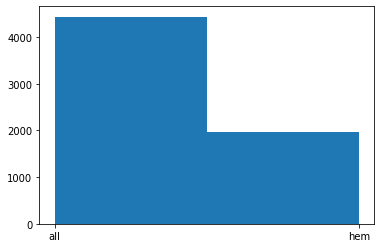

In [7]:
all_samples = [entry for entry in training_set if entry.split(".")[0][-3:] == 'all']
hem_samples = [entry for entry in training_set if entry.split(".")[0][-3:] == 'hem']

labels = [entry.split(".")[0][-3:] for entry in training_set]
_ = plt.hist(labels, bins=2)

print("Number of cancer cell images: " + str(len(all_samples)))
print("Number of normal cell images: " + str(len(hem_samples)))

As this unbalance could lead to problems during the training process, we want the two classes to contain the same number of images. 

In [8]:
expected_samples_per_class = num_training_samples//2
print("Number of expected images per class: " + str(expected_samples_per_class))

Number of expected images per class: 3198


For the largest class, that of cancer cells, we sub-sample by randomly selecting the desired number of images. 

In [9]:
sampled_all = random.sample(all_samples, expected_samples_per_class)
print("Number of sampled cancer cell images: " + str(len(sampled_all)))

Number of sampled cancer cell images: 3198


For the smallest class, on the other hand, we will use data augmentation. First of all, therefore, we select a sample of images on which to perform the augmentation.

In [10]:
hem_samples_needed = expected_samples_per_class - len(hem_samples)
sampled_hem = random.sample(hem_samples, hem_samples_needed)
print("Number of sampled normal cell images to perform augmentation: " + str(len(sampled_hem)))
print("Final number of normal cell images: " + str(len(sampled_hem) + len(hem_samples)))

Number of sampled normal cell images to perform augmentation: 1235
Final number of normal cell images: 3198


### Data Augmentation
In order to perform data augmentation, we use the following function, which randomly flips or rotates the original image.

In [11]:
def random_flip_or_rotation(original_image):
  '''
  random_flip_or_rotation randomly rotates or flips the image
  :param original_image: the image on which to perform the transformation
  :return: the transformed image
  '''
  if random.randint(0,1): # decide whether to flip the image or not
    horizontal = random.randint(0,1)
    if horizontal:
      new_image = tf.image.flip_left_right(original_image)
    else:
      new_image = tf.image.flip_up_down(original_image)
  else: # rotate the image of a random degree (between 90° and 270°)
    k = random.randint(1,3)
    new_image = tf.image.rot90(original_image, k)

  return np.asarray(new_image)

#### Example of flips and rotations

In [12]:
original_image = cv2.imread(dataset_path + "/all/UID_11_10_1_all.bmp")
vertical_flip = tf.image.flip_up_down(original_image)
horizontal_flip = tf.image.flip_left_right(original_image)
rotation_90 = tf.image.rot90(original_image, k=1)
rotation_180 = tf.image.rot90(original_image, k=2)
rotation_270 = tf.image.rot90(original_image, k=3)

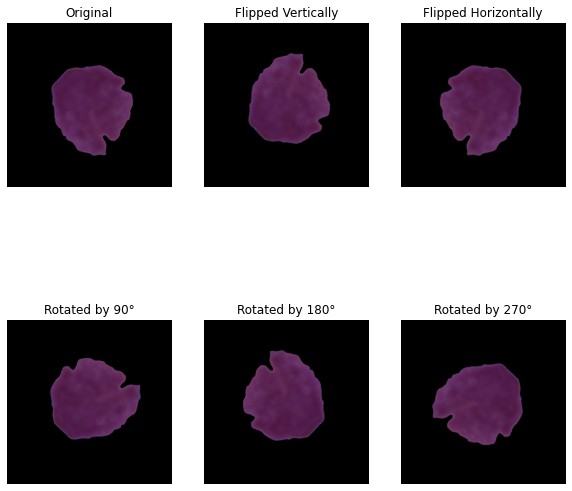

In [13]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original")

fig.add_subplot(2, 3, 2)
plt.imshow(vertical_flip)
plt.axis('off')
plt.title("Flipped Vertically")

fig.add_subplot(2, 3, 3)
plt.imshow(horizontal_flip)
plt.axis('off')
plt.title("Flipped Horizontally")

fig.add_subplot(2, 3, 4)
plt.imshow(rotation_90)
plt.axis('off')
plt.title("Rotated by 90°")

fig.add_subplot(2, 3, 5)
plt.imshow(rotation_180)
plt.axis('off')
plt.title("Rotated by 180°")

fig.add_subplot(2, 3, 6)
plt.imshow(rotation_270)
plt.axis('off')
_ = plt.title("Rotated by 270°")

## Center Cropping
Since the images contain a lot of background, we want to crop them to remove as much the black outline as much as possible. 

In order to do that, we define the following function that uses the tresholding technique and then adds some black padding.

In [14]:
def crop_and_resize_image(image):
  ''' 
  crop_image crops the image with a thresholding technique (If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value)
  :param image: image to crop
  :return: image cropped and resized
  '''
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # 'tresh' is the image thresholded
  _,thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY) # 1 is the threshold value, 255 is the maximum value
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours[0] # we have a single object in the image, so we take the first contour
  x,y,w,h = cv2.boundingRect(cnt)
  cropped_image = image[y:y+h, x:x+w]

  # Enlarge the image to get a square shape
  max_dimension = max(cropped_image.shape)
  vertical_gap = max_dimension - cropped_image.shape[0]
  if vertical_gap % 2 == 0: # even
    top = bottom = vertical_gap // 2
  else:
    top = vertical_gap // 2
    bottom = top + 1
  horizontal_gap = max_dimension - cropped_image.shape[1]
  if horizontal_gap % 2 == 0: # even
    left = right = horizontal_gap // 2
  else:
    left = horizontal_gap // 2
    right = left + 1
  return cv2.copyMakeBorder(cropped_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0) # value=0 for black

### Example of Center Cropping
Just to give an example, let us take the first image of the dataset.


After cropping, the resulting image is as follows.

In [ ]:
cropped_image = crop_and_resize_image(img)
cv2_imshow(cropped_image)
cropped_image.shape

## Store Preprocessed Dataset
At this point, all we have to do is to store the dataset divided into the three sets, applying data augmentation and image cropping. 

To begin with, we prepare all the necessary folders. 

In [16]:
new_dataset_path = "SplittedDataset"
training_path = new_dataset_path + "/training_set"
validation_path = new_dataset_path + "/validation_set"
test_path = new_dataset_path + "/test_set"

In [17]:
# remove the old folder 'SplittedDataset'
shutil.rmtree(new_dataset_path, ignore_errors=True)

# create the structure
os.makedirs(new_dataset_path)
os.makedirs(training_path)
os.makedirs(validation_path)
os.makedirs(test_path)
os.makedirs(training_path + "/all")
os.makedirs(validation_path + "/all")
os.makedirs(test_path + "/all")
os.makedirs(training_path + "/hem")
os.makedirs(validation_path + "/hem")
os.makedirs(test_path + "/hem")

First, we store the training set.

In [18]:
for sample in sampled_all: # store cropped cancer cell images
  if sample == ".ipynb_checkpoints":
    continue
  img = cv2.imread(dataset_path + '/all/' + sample)
  cropped_image = crop_and_resize_image(img)
  cv2.imwrite(training_path + '/all/' + sample, cropped_image)

for sample in hem_samples: # store cropped normal cell images
  if sample == ".ipynb_checkpoints":
    continue
  img = cv2.imread(dataset_path + '/hem/' + sample)
  cropped_image = crop_and_resize_image(img)
  cv2.imwrite(training_path + '/hem/' + sample, cropped_image)

for sample in sampled_hem: # store cropped normal cell augmented images
  if sample == ".ipynb_checkpoints":
    continue
  img = cv2.imread(dataset_path + "/hem/" + sample)
  augmented_img = random_flip_or_rotation(img)
  cropped_image = crop_and_resize_image(augmented_img)
  cv2.imwrite(training_path + '/hem/augmented_' + sample, cropped_image)

Then, the validation set.

In [19]:
for sample in validation_set: # store cropped validation set images
  if sample == ".ipynb_checkpoints":
    continue
  label = sample.split(".")[0][-3:]
  img = cv2.imread(dataset_path + '/' + label + '/' + sample)
  cropped_image = crop_and_resize_image(img)
  cv2.imwrite(validation_path + '/' + label +'/' + sample, cropped_image)

Finally, the test set.

In [20]:
for sample in test_set: # store cropped test set images
  if sample == ".ipynb_checkpoints":
    continue
  label = sample.split(".")[0][-3:]
  img = cv2.imread(dataset_path + '/' + label + '/' + sample)
  if img is None:
        print(sample)
  cropped_image = crop_and_resize_image(img)
  cv2.imwrite(test_path + '/' + label +'/' + sample, cropped_image)